## Google Play Store App Rating Prediction

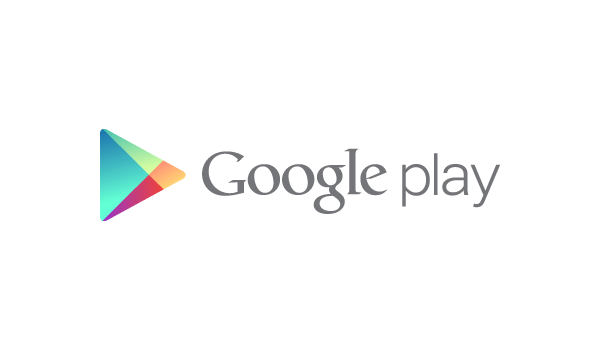

In [1]:
from IPython.display import Image
Image(filename='google-play-store.png', width = 500)

In this notebook, I will use KNN, random forest, and gradient boosting models to predict the ratings of various apps in the Google Play store.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import re
import sys

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
df = pd.read_csv('googleplaystore1.csv')

In [4]:
df.head()
# Here I will check the data type of the columns

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [6]:
df.isnull().sum()
# Checking the number of missing values for each column

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [7]:
# I will use the median value to replace null values in 'Rating'
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

In [8]:
# Clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

In [9]:
df['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION', '1.9'], dtype=object)

In [10]:
# Dropping this category since it is not reasonable
i = df[df['Category'] == '1.9'].index
df.loc[i]
df = df.drop(i)

In [11]:
# Remove null values from our data
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

### Feature Engineering

In [12]:
le = preprocessing.LabelEncoder()

In [13]:
# The 'App' values will be converted into numeric
df['App'] = le.fit_transform(df['App'])

In [14]:
category_list = df['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df = pd.concat([df, pd.get_dummies(df['Category'], prefix='cat')], axis=1)

In [15]:
df['Genres'] = le.fit_transform(df['Genres'])

In [16]:
df['Content Rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+', 'Adults only 18+',
       'Unrated'], dtype=object)

In [17]:
df['Content Rating'] = le.fit_transform(df['Content Rating'])

In [18]:
# Remove $ symbol from 'Price' values
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))

In [19]:
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

In [20]:
df['Type'].unique()

array(['Free', 'Paid', nan], dtype=object)

In [21]:
# Get dummy variables for type
df['Type'] = pd.get_dummies(df['Type'])
df.Type.unique()

array([1, 0], dtype=uint64)

In [22]:
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

In [23]:
# Size cleaning
df['Size'] = df['Size'].apply(lambda x: x.strip('M').strip('k'))
df[df['Size'] == 'Varies with device'] = 0

## Data Visualizations

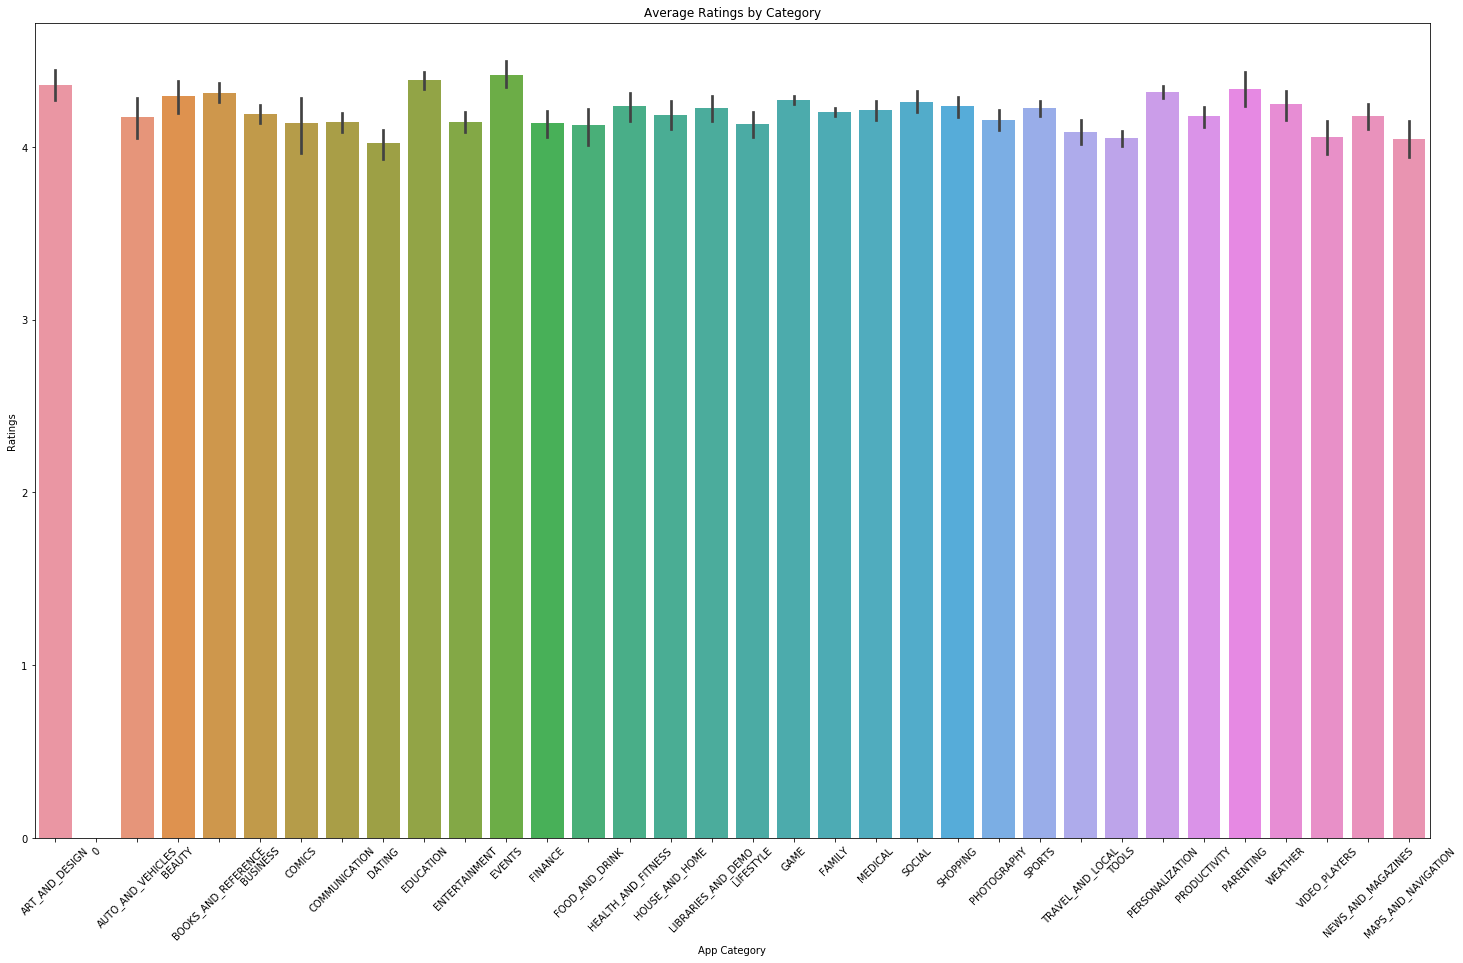

In [24]:
plt.figure(figsize=(25,15))
sns.barplot(x=df.Category, y=df.Rating)

plt.xticks(rotation = 45)
plt.xlabel('App Category')
plt.ylabel('Ratings')
plt.title('Average Ratings by Category')
plt.show()

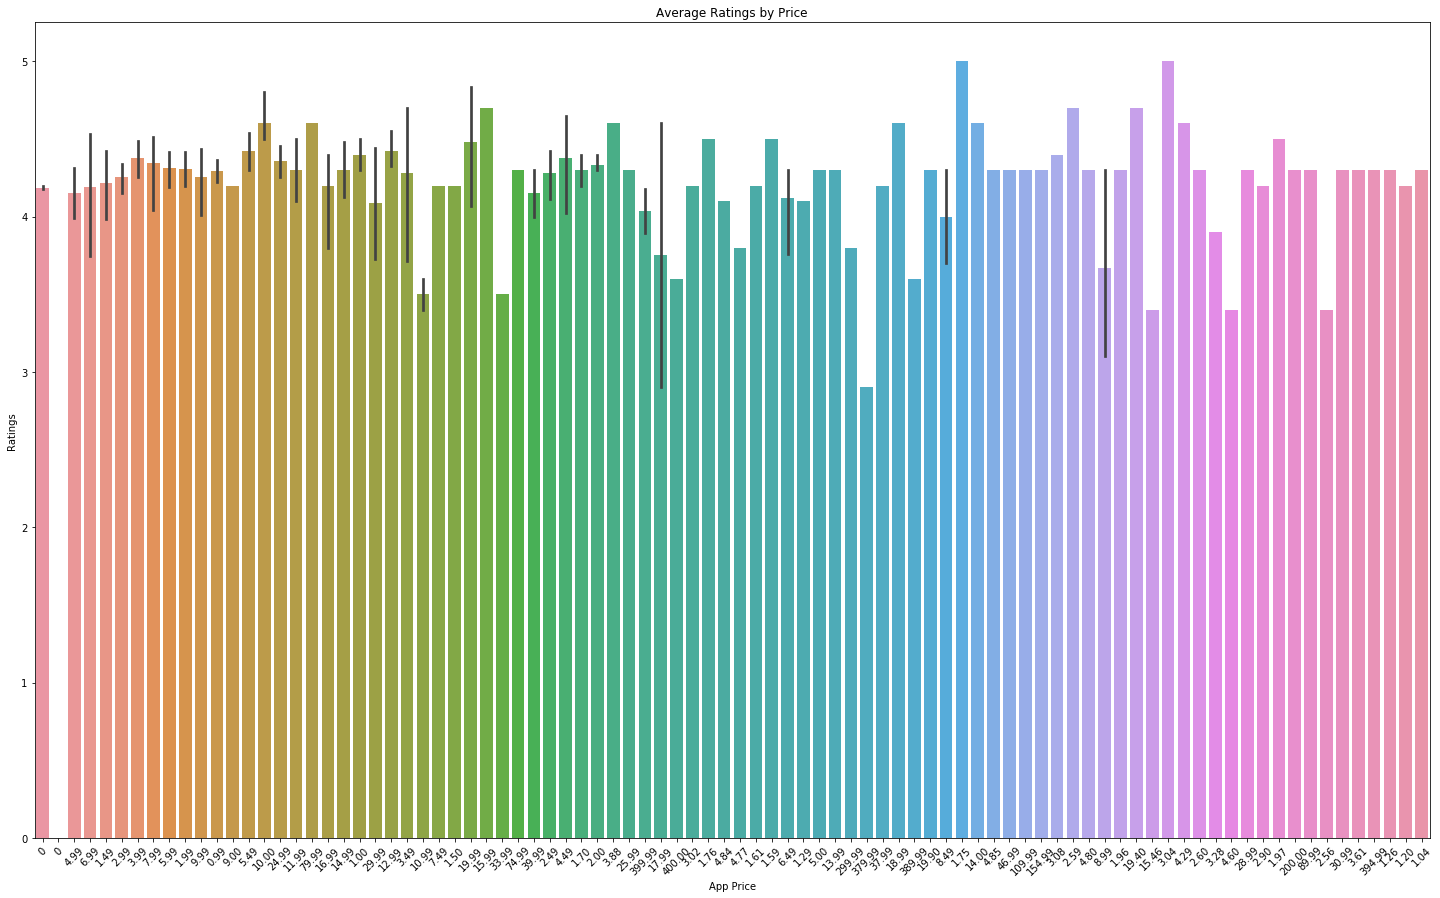

In [25]:
plt.figure(figsize=(25,15))
sns.barplot(x=df.Price, y=df.Rating)

plt.xticks(rotation = 45)
plt.xlabel('App Price')
plt.ylabel('Ratings')
plt.title('Average Ratings by Price')
plt.show()

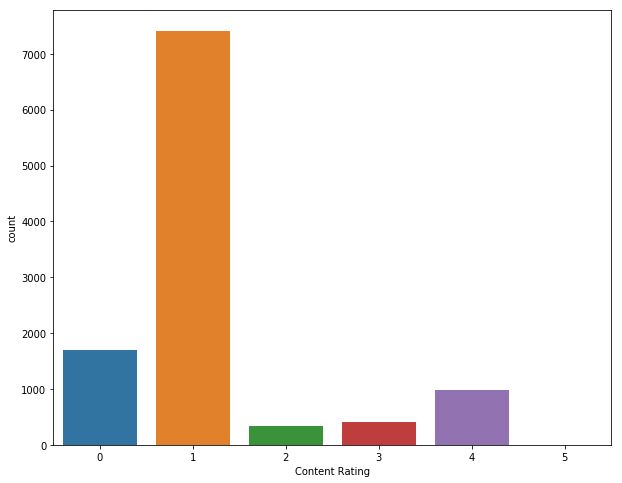

In [26]:
plt.figure(figsize = (10,8))
sns.countplot(df['Content Rating'])
plt.show()
#'Everyone', 'Teen', 'Everyone 10+', 'Mature 17+', 'Adults only 18+','Unrated'

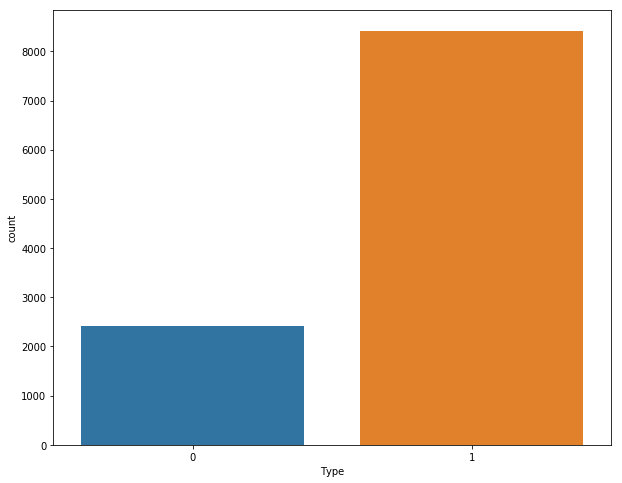

In [27]:
plt.figure(figsize = (10,8))
sns.countplot(df['Type'])
plt.show()


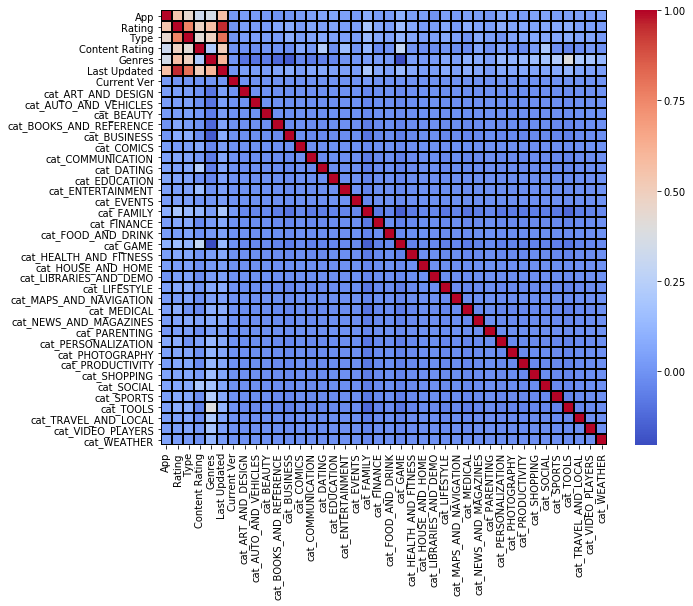

In [28]:
correlation_matrix = df.corr()
fig, ax = plt.subplots(figsize=(10,8))  
sns.heatmap(correlation_matrix, linecolor='k', linewidths=1, cmap= 'coolwarm', ax= ax)

## Models

In this section, I will use KNN, Random Forest, and Gradient Boosting models to predict the app ratings based on our set of features. The independent variables will be the features and the target variable will be 'Ratings'. The variables will be split into a training and test set.

In [29]:
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
X = df[features]
y = df['Rating']

In [30]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.20, random_state = 10)

### KNN Model

The KNN algorithm is based around the simple idea of predicting unknown values by matching them with the most similar known values. Building the model consists only of storing the training dataset. To make a prediction for a new data point, the algorithm finds the closest data points in the training dataset — its "nearest neighbors".

In [31]:
knn = KNeighborsRegressor(n_neighbors = 15)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='uniform')

In [32]:
accuracy = knn.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 92.1%'

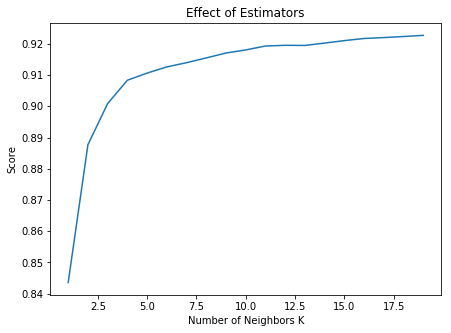

In [33]:
n_neighbors = np.arange(1, 20, 1)
scores = []
for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

### Gradient Boosting Model

In [34]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [35]:
accuracy = gb.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 93.37%'

### Random Forest Model

[(10, 0.92813868546242317),
 (20, 0.93120566811134753),
 (30, 0.93364703021490314),
 (40, 0.93568458973653335),
 (50, 0.93405808902422516),
 (60, 0.93442418075754774),
 (70, 0.93462396748868837),
 (80, 0.93329455385844728),
 (90, 0.93564816147005125),
 (100, 0.93459838225736869),
 (110, 0.93553650470869099),
 (120, 0.93486079640517727),
 (130, 0.93484056427485662),
 (140, 0.93465162322646478),
 (150, 0.93418983074142525),
 (160, 0.93545682392505802),
 (170, 0.93523213514296144),
 (180, 0.9353021965320566),
 (190, 0.93553463656856128)]

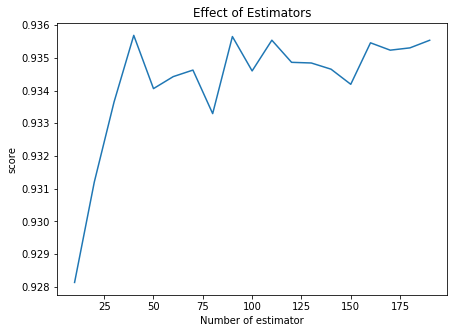

In [36]:
rf = RandomForestRegressor(n_jobs=-1)
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
results = list(zip(estimators,scores))
results

# Conclusion

-   After comparing different models for predicting the app rating, it seems that best model was the random forest model. This model had an accuracy score of 93.5% at when using n =100 for the number of estimators

-  The other models performed well with the gradient boosting model having an accuracy score of 93.37% and the knn model having a score of 92.1%


-   I will double check the correlation of the features to ensure that this score is accurate and not caused by over fitting. 